In [16]:
import pandas as pd
import numpy as np

from funcs.ad import get_sigma_values

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from adjustText import adjust_text

import seaborn as sns


def colorcode_rotation(st_rotp):
    """Define color code and symbol marker for rotation period.

    Parameters
    ----------
    st_rotp : float
        Rotation period in days.

    Returns
    -------
    color : str
        Color code.
    marker : str
        Symbol marker.
    """
    if st_rotp < 10.:
        color = "green"
        symbol = "o"

    elif (st_rotp >= 10.) & (st_rotp < 15.):
        color = "blue"
        symbol = "x"

    elif (st_rotp >= 15.):
        color = "black"
        symbol = "d"

    else:
        color = "lightgrey"
        symbol = "s"

    return color, symbol

df = pd.read_csv("../results/results.csv", index_col=0)

# define the colors and symbols for the different rotation periods
df["color"], df["symbol"] = zip(
    *df.st_rotp.apply(colorcode_rotation))


In [17]:
# ------------------------------------------------------------
# Plotting setup
# get reference sigma values
sigmas, sigma_labels = get_sigma_values()

# define legend elements
legend = [Line2D([0], [0], marker='X', color='w',
          markerfacecolor='blue', markersize=10),
          Line2D([0], [0], marker='d', color='w',
          markerfacecolor='black', markersize=10),
          Line2D([0], [0], marker='o', color='w',
          markerfacecolor='green', markersize=10),
          Line2D([0], [0], marker='s', color='w',
          markerfacecolor='lightgrey', markersize=10)]

# define legend labels
labels = [r"$10 \leq P_{rot} < 15$ d",
          r"$P_{rot} \geq 15$ d",
          r"$P_{rot} < 10$ d",
          r"no $P_{rot}$"]

# ------------------------------------------------------------

In [18]:
df[["p_spi_erg_s","p_spi_erg_s_bp0"]]

,p_spi_erg_s,p_spi_erg_s_bp0
TIC,,
26417717,NaN,NaN
27769688,NaN,NaN
28159518,NaN,NaN
28230919,6.802920e+29,2.052341e+31
43605290,2.242212e+30,5.770460e+32
48353358,9.390040e+29,1.315422e+32
63126862,NaN,NaN
67646988,NaN,NaN
98796344,NaN,NaN


143

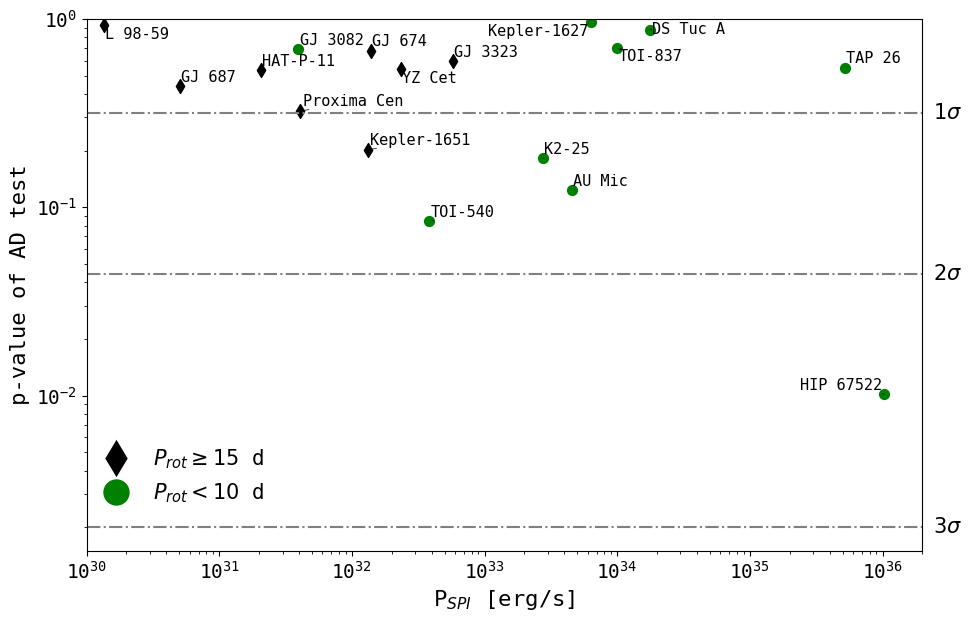

In [21]:
# P-VALUE VS. P_SPI

# set up figure
fig, ax = plt.subplots(figsize=(10, 6.5))

data = df[df.p_spi_erg_s.notnull()]

texts = []

# plot the data
for color, group in data.groupby("color"):
    plt.scatter(group["p_spi_erg_s_bp0"], group["mean"], marker=group["symbol"].iloc[0],
                c=color, s=50., alpha=1.)
    for star, row in group.iterrows():
        texts.append(plt.text(x=row["p_spi_erg_s_bp0"], y=row["mean"], s=row["ID"],
                    fontsize=11, ha="right", va="top", rotation=0))
    # if (color != "lightgrey") & (color != "blue"):
    #     sns.kdeplot(data=group, x="p_spi", y="mean", fill=True,
    #                 color=color, common_norm=True, alpha=.4, log_scale=True,
    #                 cut=0., levels=[0.32, 0.68, 0.95, 0.997])


# log scale
plt.yscale("log")
plt.xscale("log")

# add sigma lines
for sigma, label in list(zip(sigmas, sigma_labels)):
    plt.axhline(sigma, color="grey", linestyle="-.")
    plt.text(2.4e36, sigma, label, fontsize=15,
             color="k", verticalalignment="center")

# labels
plt.ylabel("p-value of AD test")
plt.xlabel("P$_{SPI}$ [erg/s]")

# legend
plt.legend(legend[1:3], labels[1:3], loc=(0, 0.07), fontsize=15)

# limits
plt.xlim(1e30, 2e36)
plt.ylim(1.5e-3, 1)

adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
# # save figure
# plt.savefig("../results/plots/adtests_vs_pspi_kde_bp0.png",
#             dpi=300)


# ------------------------------------------------------------


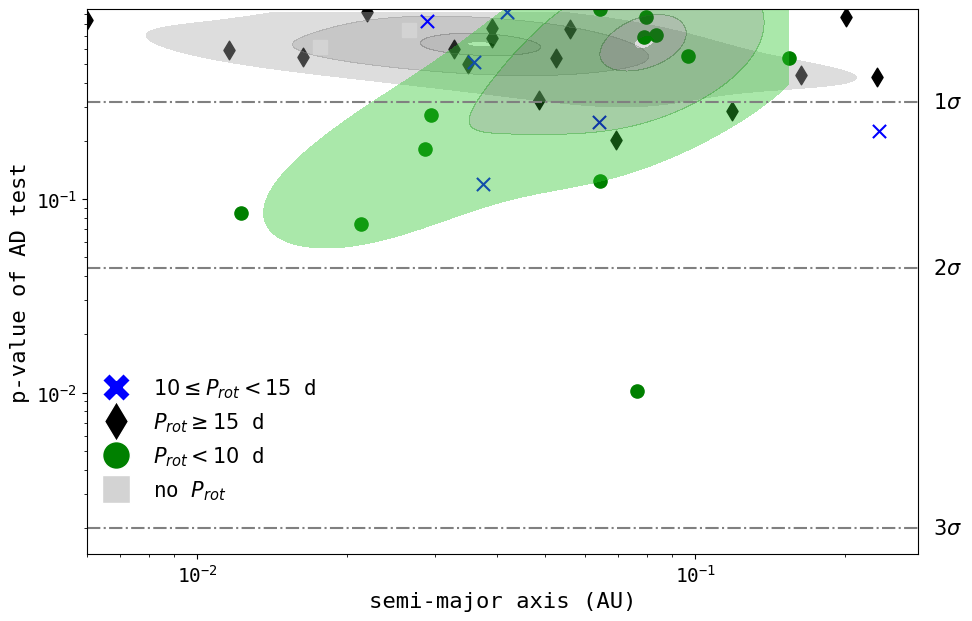

In [23]:
# P-VALUE VS. SEMI-MAJOR AXIS

# set up figure
fig, ax = plt.subplots(figsize=(10, 6.5))


# plot the data
for color, group in df.groupby("color"):
    plt.scatter(group["a_au"], group["mean"], marker=group["symbol"].iloc[0],
                c=color, s=90., alpha=1.)
    if (color != "lightgrey") & (color != "blue"):
        sns.kdeplot(data=group, x="a_au", y="mean", fill=True,
                    color=color, common_norm=True, alpha=.4, log_scale=True,
                    cut=0., levels=[0.32, 0.68, 0.95, 0.997])


# log scale
plt.yscale("log")
plt.xscale("log")

# add sigma lines
for sigma, label in list(zip(sigmas, sigma_labels)):
    plt.axhline(sigma, color="grey", linestyle="-.")
    plt.text(.3, sigma, label, fontsize=15,
             color="k", verticalalignment="center")

# labels
plt.ylabel("p-value of AD test")
plt.xlabel("semi-major axis (AU)")

# legend
plt.legend(legend, labels, loc=(0, 0.08), fontsize=15)

# save figure
plt.savefig("../results/plots/adtests_vs_semimajor_axis_kde.png",
            dpi=300)

# ------------------------------------------------------------


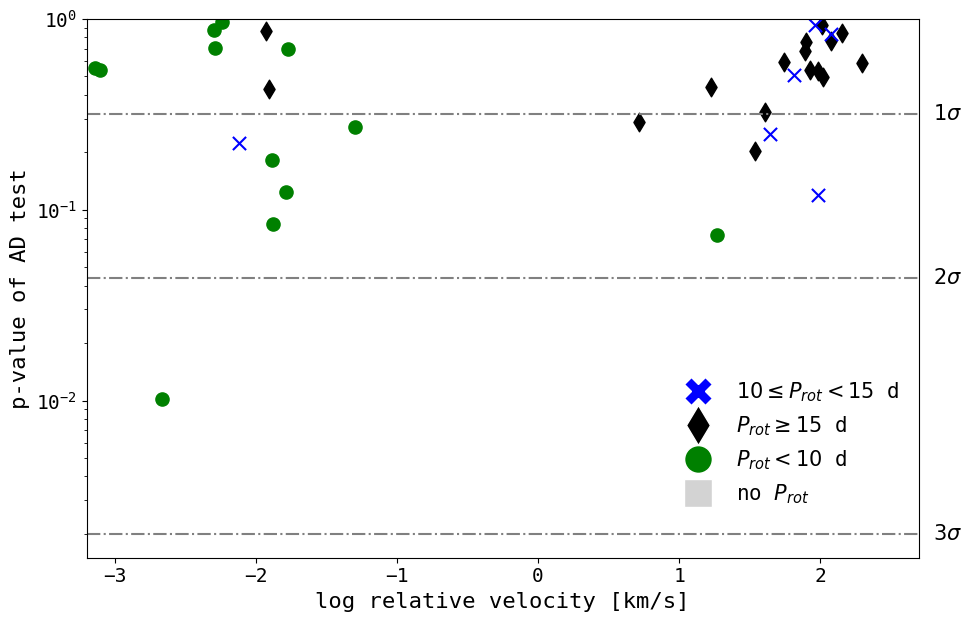

In [26]:
# P-VALUE VS. SEMI-MAJOR AXIS

# set up figure
fig, ax = plt.subplots(figsize=(10, 6.5))

df["vrellog"] = np.sign(df.v_rel_km_s) * np.log10(
                                                np.abs(df.v_rel_km_s))
# plot the data
for color, group in df.groupby("color"):
    plt.scatter(group["vrellog"], group["mean"], marker=group["symbol"].iloc[0],
                c=color, s=90., alpha=1.)
    # if (color != "lightgrey") & (color != "blue"):
    #     sns.kdeplot(data=group, x="vrellog", y="mean", fill=True,
    #                 color=color, common_norm=True, alpha=.4, #log_scale=True,
    #                 cut=0., levels=[0.32, 0.68, 0.95, 0.997])


# log scale
plt.yscale("log")
# plt.xscale("log")

# # add sigma lines
for sigma, label in list(zip(sigmas, sigma_labels)):
    plt.axhline(sigma, color="grey", linestyle="-.")
    plt.text(2.8, sigma, label, fontsize=15,
             color="k", verticalalignment="center")

# labels
plt.ylabel("p-value of AD test")
plt.xlabel("log relative velocity [km/s]")

# limits
plt.xlim(-3.2, 2.7)
plt.ylim(1.5e-3, 1)

# legend
plt.legend(legend, labels, loc=(.7, 0.08), fontsize=15)

# save figure
plt.savefig("../results/plots/2022_11_22_adtests_vs_vrel_kde.png",
            dpi=300)

# ------------------------------------------------------------


Text(0.5, 0, 'orbital period [days]')

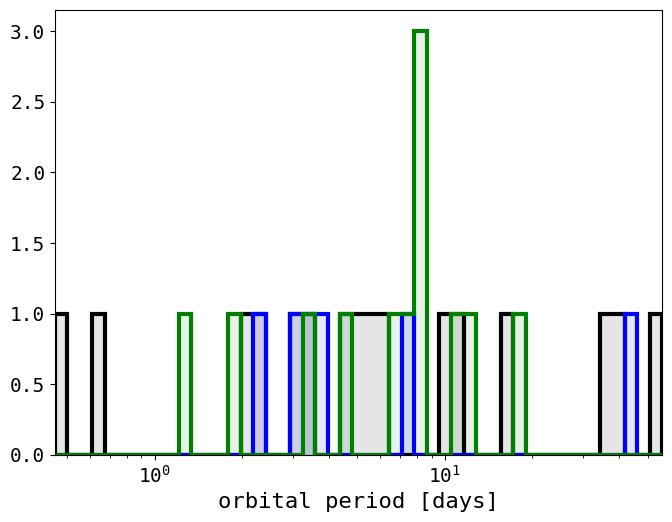

In [35]:
minper, maxper = df.orbper_d.min(), df.orbper_d.max()

# set up figure
fig, ax = plt.subplots(figsize=(7, 5.5))

bins = np.logspace(np.log10(minper), np.log10(maxper), 50)

for color, group in df.groupby("color"):
    if color != "lightgrey":
        plt.hist(group.orbper_d, color=color, bins=bins, histtype="step", linewidth=3)
        plt.hist(group.orbper_d, color=color, bins=bins, alpha=.1)
    # 
    #     sns.kdeplot(data=group, x="orbper_d",
    #                 fill=True, alpha=0.4, color=color)

plt.xscale("log")
# plt.yscale("log")
plt.xlim(minper, maxper)
# plt.ylim(minper, maxper)
# plt.xlabel("rotation period [days]")
plt.xlabel("orbital period [days]")


In [ ]:
minflares, maxflares = df.number_of_flares.min(), df.number_of_flares.max()

# set up figure
fig, ax = plt.subplots(figsize=(7, 5.5))

for color, group in df.groupby("color"):
    # plt.hist(group.orbper_d, color=color, bins=bins)
    if color != "lightgrey":
        sns.kdeplot(data=group, x="number_of_flares",
                    fill=True, alpha=0.3, color=color)


# plt.xscale("log")
# plt.yscale("log")
plt.xlim(minper, maxper)
# plt.ylim(minper, maxper)
plt.xlabel("number of flares")
plt.ylabel("density")


idea: AD text vs. a/R plot

In [ ]:
# define legend elements
legend = [Line2D([0], [0], marker='', color='black',
          markerfacecolor='black', markersize=10),
          Line2D([0], [0], marker='', color='blue',
          markerfacecolor='blue', markersize=10),
          Line2D([0], [0], marker='', color='green',
          markerfacecolor='green', markersize=10), ]

# define legend labels
labels = [r"$P_{rot} \geq 15$ d",
          r"$10 \leq P_{rot} < 15$ d",
          r"$P_{rot} < 10$ d", ]

# set up figure
fig, ax = plt.subplots(figsize=(7, 5.5))
bins = np.logspace(-2.1, 0, 10)
for color, group in df.groupby("color"):
    if color != "lightgrey":
        # plt.hist(group["mean"], linewidth=4,
        #       color=color, bins=bins, alpha=0.5, label=color)
        sns.kdeplot(data=group, x="mean", fill=True, color=color, cut=0)


# plt.xscale("log")
# plt.yscale("log")
plt.xlim(0, 1)
# plt.ylim(minper, maxper)
#plt.xlabel("semi-major axis [AU]")
plt.xlabel("p-value of AD test")

# legeng
plt.legend(legend, labels, loc=2, fontsize=15)

# save figure
plt.savefig("../results/plots/2022_11_22_adtests_kde_vs_rotation.png", dpi=300)


In [ ]:


minper, maxper = df.orbits_covered.min(), df.orbits_covered.max()


# set up figure
fig, ax = plt.subplots(figsize=(7, 5.5))


for color, group in df.groupby("color"):
    # print(rotp, np.mean(group.orbits_covered))
    # print(color)
    if color != "lightgrey":
        sns.kdeplot(data=group, x="orbits_covered", fill=True,
                    color=color, common_norm=True, alpha=.3, log_scale=True, cut=0
                    )

plt.xscale("log")
plt.yscale("log")
# plt.xlim(minper, maxper)
# plt.ylim(minper, maxper)
plt.ylabel("density")
plt.xlabel("number of orbits covered")

# legeng
plt.legend(legend, labels, loc=1, fontsize=13.5)


# Compare to fake p-value calculations

In [ ]:
# read in AD test results
adtests = pd.read_csv("../results/multistar_adtest.csv")

# get different modes
modes = adtests["period"].unique()

# read in the table of known parameters from the NASA Exoplanet Archive and TESS
sps_w_ad = pd.read_csv(
    "../results/params_of_star_planet_systems_with_AD_tests.csv")

# read in age and rotation period from the literature search
literature_params = pd.read_csv(
    "../results/2022_09_stellar_params_with_coherence_times.csv")
literature_params.TIC = literature_params.TIC.astype(str)

res = pd.DataFrame()
print(res.shape)
# aggregate the p-values
for mode in modes:

    df = aggregate_pvalues(adtests, subsample="ED>1s", period=mode)
    print(mode)

    df = df[["TIC", "mean"]]

    if res.shape[0] == 0:
        res = df.set_index("TIC")
    else:
        # join the the table to res as a new column
        res = res.merge(df, on="TIC", how="left")

    res = res.rename(columns={"mean": f"mean_{mode}"})

# merge the AD test results with the stellar parameters
res = res.merge(literature_params, on=["TIC"], how="left")


In [ ]:
res.columns


In [ ]:
plt.figure(figsize=(9, 6.5))

for mode in modes:
    if mode == "orbit":
        o = 10
        histtype = "bar"
    else:
        o = 1
        histtype = "step"
    plt.hist(res[f"mean_{mode}"], bins=np.logspace(-3, 0, 15),
             label=mode.replace("_", " "), linewidth=3, zorder=o, alpha=.5, histtype=histtype)

plt.xscale("log")
plt.legend(loc=2)
plt.xlabel("p-value of AD test")
plt.ylabel("number of stars")


In [41]:
df[["orbper_d","st_rad","pl_radj","number_of_flares","orbits_covered","xray_flux_erg_s","B_G","p_spi_erg_s"]].corr()

,orbper_d,st_rad,pl_radj,number_of_flares,orbits_covered,xray_flux_erg_s,B_G,p_spi_erg_s
orbper_d,1.000000,0.182284,0.066312,-0.132844,-0.214400,-0.032626,-0.358240,0.051179
st_rad,0.182284,1.000000,0.777832,-0.116111,-0.194248,0.728164,0.040165,0.570059
pl_radj,0.066312,0.777832,1.000000,0.049762,-0.180800,0.583264,-0.013488,0.801924
number_of_flares,-0.132844,-0.116111,0.049762,1.000000,0.015861,-0.129403,0.081753,-0.134981
orbits_covered,-0.214400,-0.194248,-0.180800,0.015861,1.000000,-0.224671,-0.381629,-0.185817
xray_flux_erg_s,-0.032626,0.728164,0.583264,-0.129403,-0.224671,1.000000,0.342663,0.498164
B_G,-0.358240,0.040165,-0.013488,0.081753,-0.381629,0.342663,1.000000,0.138896
p_spi_erg_s,0.051179,0.570059,0.801924,-0.134981,-0.185817,0.498164,0.138896,1.000000


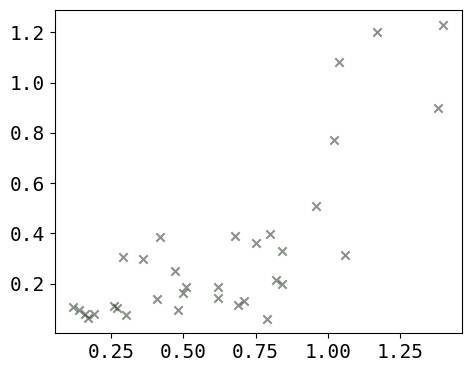

In [39]:
plt.scatter(df.st_rad, df.pl_radj)